In [4]:
# fig_fomc_simulation.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# ───────────────────────────────────────
# 🔧 Parameters
# ───────────────────────────────────────
S0 = 36.50          # Current price (Dec 3)
K = 38.0            # Call strike
call_premium = 2.50 # Estimated market price for Dec 26 $38 Call
T_days = 23         # Trading days to Dec 26
r = 0.045           # Risk-free rate (annual)
sigma_ann = 0.65    # Annualized volatility (73% IV)
sigma = sigma_ann / np.sqrt(252)  # Daily vol

# FOMC: Day 10 (Dec 17 is ~10 trading days from Dec 3)
fomc_day = 10
jump_scenarios = {
    'Base': 0.0,         # No jump
    'Bullish_FOMC': 0.05, # +5% jump (dovish cut)
    'Bearish_FOMC': -0.05 # -5% jump (hawkish/no cut)
}

n_sim = 100_000  # Number of Monte Carlo paths

# ───────────────────────────────────────
# 🧮 Simulation Function
# ───────────────────────────────────────
def simulate_paths(jump=0.0, n=n_sim):
    """
    Simulate FIG price paths with optional jump on day=fomc_day.
    Returns: final prices array (size n)
    """
    # Pre-allocate
    prices = np.full((n, T_days + 1), S0)
    
    # Generate daily returns: drift + diffusion
    # Drift = (r - 0.5*sigma^2) * dt, but for short horizon, often set drift=0
    drift = 0.0  # Risk-neutral or real-world? We use 0 for simplicity (focus on vol/jump)
    dt = 1  # 1 day
    
    for t in range(1, T_days + 1):
        z = np.random.standard_normal(n)
        # GBM step
        prices[:, t] = prices[:, t-1] * np.exp(
            drift * dt + sigma * np.sqrt(dt) * z
        )
        # Apply jump on FOMC day
        if t == fomc_day:
            prices[:, t] *= (1 + jump)
    
    return prices[:, -1]  # Final prices on Dec 26

# Add to your simulation: stochastic volatility (simplified)
# Inspired by SABR / Heston (but lightweight for estimation)

def simulate_paths_with_iv_jump(jump=0.0, iv_jump=0.0, n=n_sim):
    S = np.full(n, S0)
    sigma_t = np.full(n, sigma_ann)  # Start at 60%
    
    for t in range(1, T_days + 1):
        # Random vol shock (mean-reverting)
        vol_shock = np.random.normal(0, 0.1, n)  # 10% daily vol-of-vol
        sigma_t = np.clip(sigma_t * (1 + vol_shock), 0.2, 2.0)  # Bound 20%–200%
        
        # Apply event-driven IV jump on FOMC day
        if t == fomc_day:
            sigma_t *= (1 + iv_jump)  # e.g., +0.25 → 25% IV surge
        
        # GBM with time-varying vol
        z = np.random.standard_normal(n)
        S = S * np.exp(
            -0.5 * (sigma_t/np.sqrt(252))**2 + 
            (sigma_t/np.sqrt(252)) * z
        )
        if t == fomc_day:
            S *= (1 + jump)
    
    return S
    

Running Base scenario...
Running Bullish_FOMC scenario...
Running Bearish_FOMC scenario...

📈 FIG Dec 26 $38.0 Call (Premium = $2.5) — Risk & Return Summary
Scenario        Prob Profit  Avg PnL    VaR_95     ES_95     
----------------------------------------------------------------------
Base            30.0%        $ +0.09     $ -2.50    $ -2.50
Bullish_FOMC    39.1%        $ +1.10     $ -2.50    $ -2.50
Bearish_FOMC    21.5%        $ -0.76     $ -2.50    $ -2.50


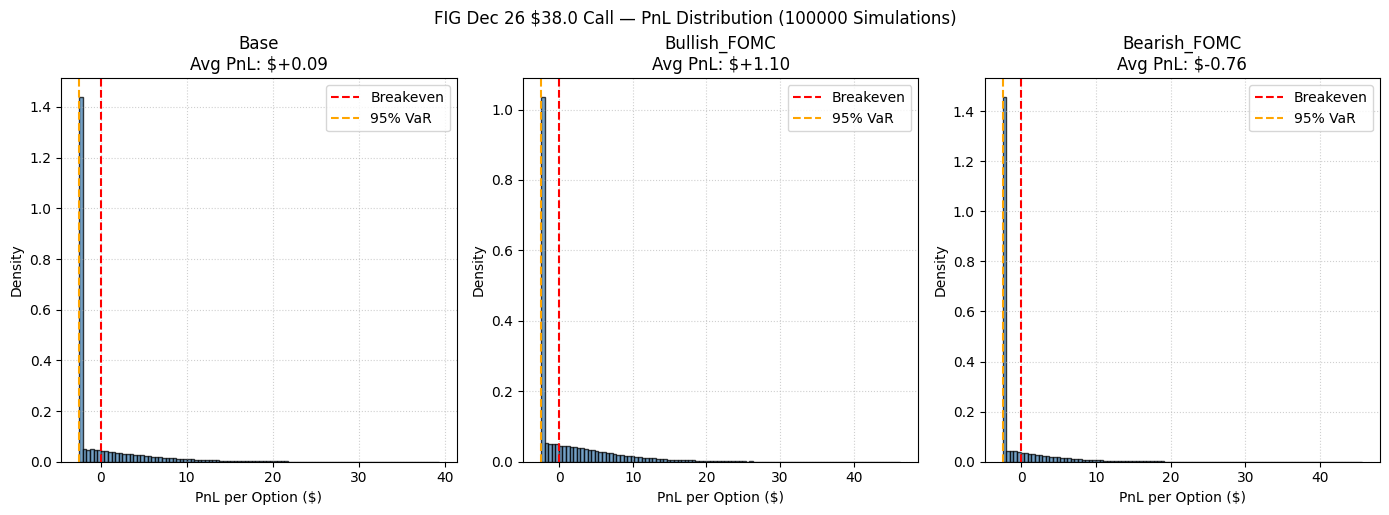


🎯 Target Prices for Dec 26 $38.0 Call:
----------------------------------------
→ PnL = $+0.00  →  FIG ≥ $40.50  (+11.0% from now)
→ PnL = $+2.50  →  FIG ≥ $43.00  (+17.8% from now)
→ PnL = $+5.00  →  FIG ≥ $45.50  (+24.7% from now)


In [5]:

# ───────────────────────────────────────
# 📊 Run simulations & analyze
# ───────────────────────────────────────
results = {}

for name, jump in jump_scenarios.items():
    print(f"Running {name} scenario...")
    final_prices = simulate_paths(jump=jump, n=n_sim)
    
    # Call payoff: max(S_T - K, 0) - premium
    payoffs = np.maximum(final_prices - K, 0) - call_premium
    
    # Risk metrics
    var_95 = np.percentile(payoffs, 5)  # 95% VaR (loss not exceeded 95% of time)
    es_95 = payoffs[payoffs <= var_95].mean()  # Expected Shortfall
    prob_profit = np.mean(payoffs > 0)
    avg_pnl = payoffs.mean()
    std_pnl = payoffs.std()
    
    results[name] = {
        'final_prices': final_prices,
        'payoffs': payoffs,
        'VaR_95': var_95,
        'ES_95': es_95,
        'Prob_Profit': prob_profit,
        'Avg_PnL': avg_pnl,
        'Std_PnL': std_pnl
    }

# ───────────────────────────────────────
# 📋 Print Summary Table
# ───────────────────────────────────────
print("\n" + "="*70)
print(f"📈 FIG Dec 26 ${K} Call (Premium = ${call_premium}) — Risk & Return Summary")
print("="*70)
print(f"{'Scenario':<15} {'Prob Profit':<12} {'Avg PnL':<10} {'VaR_95':<10} {'ES_95':<10}")
print("-"*70)
for name, res in results.items():
    print(f"{name:<15} "
          f"{res['Prob_Profit']:.1%}        "
          f"${res['Avg_PnL']:+6.2f}     "
          f"${res['VaR_95']:+6.2f}    "
          f"${res['ES_95']:+6.2f}")

# ───────────────────────────────────────
# 📉 Plot histograms
# ───────────────────────────────────────
plt.figure(figsize=(14, 5))

for i, (name, res) in enumerate(results.items(), 1):
    plt.subplot(1, 3, i)
    plt.hist(res['payoffs'], bins=100, alpha=0.75, color='steelblue', edgecolor='black', density=True)
    plt.axvline(0, color='red', linestyle='--', label='Breakeven')
    plt.axvline(res['VaR_95'], color='orange', linestyle='--', label='95% VaR')
    plt.title(f'{name}\nAvg PnL: ${res["Avg_PnL"]:+.2f}')
    plt.xlabel('PnL per Option ($)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.suptitle(f'FIG Dec 26 ${K} Call — PnL Distribution ({n_sim} Simulations)', y=1.02)
plt.show()

# ───────────────────────────────────────
# 🔍 Bonus: What price is needed for 50%/75% profit?
# ───────────────────────────────────────
target_profit = [0, call_premium, 2*call_premium]  # Breakeven, 100%, 200% ROI
print(f"\n🎯 Target Prices for Dec 26 ${K} Call:")
print("-"*40)
for tp in target_profit:
    target_price = K + call_premium + tp
    print(f"→ PnL = ${tp:+5.2f}  →  FIG ≥ ${target_price:.2f}  ({(target_price/S0-1):+.1%} from now)")

In [6]:
# fig_option_risk_analyzer.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

class FIGOptionAnalyzer:
    def __init__(self, 
                 S0=36.10, 
                 r=0.045, 
                 iv_current=0.60, 
                 iv_mean=0.65, 
                 iv_vol_of_vol=0.40,  # Volatility of volatility
                 n_sim=100_000,
                 seed=42):
        self.S0 = S0
        self.r = r
        self.iv_current = iv_current
        self.iv_mean = iv_mean
        self.iv_vol_of_vol = iv_vol_of_vol
        self.n_sim = n_sim
        np.random.seed(seed)
    
    # ────────────────────────
    # 🔁 Core Simulation Engine
    # ────────────────────────
    def simulate_paths(self, 
                       T_days=23,
                       event_day=10,
                       price_jump=0.0,
                       iv_jump=0.0,
                       iv_decay_after_event=0.1,  # IV mean-reverts post-event
                       vol_of_vol=None):
        """
        Simulate FIG price + stochastic IV paths.
        Returns: final_prices, final_ivs
        """
        if vol_of_vol is None:
            vol_of_vol = self.iv_vol_of_vol
        
        # Initialize
        S = np.full(self.n_sim, self.S0)
        sigma = np.full(self.n_sim, self.iv_current)  # Annualized IV
        
        for t in range(1, T_days + 1):
            # Stochastic volatility (Ornstein-Uhlenbeck-like mean reversion)
            dW_vol = np.random.normal(0, 1, self.n_sim)
            sigma = sigma + 0.1 * (self.iv_mean - sigma) * (1/252) + \
                    vol_of_vol * sigma * np.sqrt(1/252) * dW_vol
            sigma = np.clip(sigma, 0.1, 2.0)  # Bound 10%–200%
            
            # Price diffusion
            dW_price = np.random.normal(0, 1, self.n_sim)
            dt = 1/252
            S = S * np.exp((self.r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * dW_price)
            
            # Apply event on event_day
            if t == event_day:
                S *= (1 + price_jump)
                sigma += iv_jump  # Additive IV jump (e.g., +0.30)
            
            # Post-event IV decay (mean reversion accelerates)
            if t > event_day:
                sigma *= (1 - iv_decay_after_event * (t - event_day) / T_days)
        
        return S, sigma

    # ────────────────────────
    # 📊 Evaluate Option PnL
    # ────────────────────────
    def evaluate_call(self, 
                      T_days=23,
                      K=38.0,
                      premium=2.30,
                      event_scenario=None,
                      event_day=10):
        """
        Evaluate a call option under a scenario.
        event_scenario: dict with 'price_jump', 'iv_jump'
        """
        if event_scenario is None:
            event_scenario = {'price_jump': 0.0, 'iv_jump': 0.0}
        
        final_prices, _ = self.simulate_paths(
            T_days=T_days,
            event_day=event_day,
            **event_scenario
        )
        
        payoffs = np.maximum(final_prices - K, 0) - premium
        
        # Risk metrics
        var_95 = np.percentile(payoffs, 5)
        es_95 = payoffs[payoffs <= var_95].mean() if np.any(payoffs <= var_95) else np.nan
        prob_profit = np.mean(payoffs > 0)
        avg_pnl = payoffs.mean()
        std_pnl = payoffs.std()
        sharpe = avg_pnl / std_pnl if std_pnl > 0 else 0
        
        return {
            'final_prices': final_prices,
            'payoffs': payoffs,
            'VaR_95': var_95,
            'ES_95': es_95,
            'Prob_Profit': prob_profit,
            'Avg_PnL': avg_pnl,
            'Std_PnL': std_pnl,
            'Sharpe': sharpe
        }

    # ────────────────────────
    # 🧪 Run Multi-Scenario Analysis
    # ────────────────────────
    def analyze_option(self, 
                       T_days=23,
                       K=38.0,
                       premium=2.30,
                       event_day=10):
        """
        Run all scenarios for one option.
        Returns: dict of results by scenario name
        """
        scenarios = {
            'Base': {'price_jump': 0.00, 'iv_jump': 0.00},
            'FOMC_Bullish': {'price_jump': 0.05, 'iv_jump': 0.15},
            'FIG_Event_Bullish': {'price_jump': 0.12, 'iv_jump': 0.30},
            'FOMC_Hawkish': {'price_jump': -0.05, 'iv_jump': -0.10},
            'FIG_Bad_News': {'price_jump': -0.10, 'iv_jump': -0.20},
        }
        
        results = {}
        for name, params in scenarios.items():
            res = self.evaluate_call(
                T_days=T_days,
                K=K,
                premium=premium,
                event_scenario=params,
                event_day=event_day
            )
            results[name] = res
        return results

    # ────────────────────────
    # 📊 Compare Multiple Options
    # ────────────────────────
    def compare_options(self, 
                        option_configs,
                        event_day=10,
                        plot=True):
        """
        option_configs: list of dicts, e.g.
        [{'T_days':23, 'K':38, 'premium':2.3, 'label':'Dec26 $38'},
         {'T_days':45, 'K':38, 'premium':4.5, 'label':'Jan17 $38'}]
        """
        summary = []
        
        for cfg in option_configs:
            res = self.analyze_option(
                T_days=cfg['T_days'],
                K=cfg['K'],
                premium=cfg['premium'],
                event_day=event_day
            )
            
            # Store key metrics (Base + Bullish scenarios)
            base = res['Base']
            bull = res['FIG_Event_Bullish']
            bear = res['FIG_Bad_News']
            
            summary.append({
                'Label': cfg['label'],
                'T_days': cfg['T_days'],
                'Strike': cfg['K'],
                'Premium': cfg['premium'],
                'Breakeven': cfg['K'] + cfg['premium'],
                'Base_Prob_Profit': base['Prob_Profit'],
                'Base_Avg_PnL': base['Avg_PnL'],
                'Bull_Prob_Profit': bull['Prob_Profit'],
                'Bull_Avg_PnL': bull['Avg_PnL'],
                'Bear_Avg_PnL': bear['Avg_PnL'],
                'VaR_95_Base': base['VaR_95'],
                'Sharpe_Base': base['Sharpe']
            })
        
        df = pd.DataFrame(summary)
        
        if plot:
            self._plot_comparison(df, option_configs)
        
        return df

    # ────────────────────────
    # 📈 Plotting
    # ────────────────────────
    def _plot_comparison(self, df, configs):
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        fig.suptitle('FIG Option Strategy Comparison', fontsize=16)
        
        # 1. Avg PnL (Base vs Bull vs Bear)
        x = np.arange(len(df))
        axes[0,0].bar(x-0.2, df['Base_Avg_PnL'], width=0.2, label='Base', color='gray')
        axes[0,0].bar(x, df['Bull_Avg_PnL'], width=0.2, label='Bullish Event', color='green')
        axes[0,0].bar(x+0.2, df['Bear_Avg_PnL'], width=0.2, label='Bad News', color='red')
        axes[0,0].set_xticks(x)
        axes[0,0].set_xticklabels(df['Label'], rotation=30)
        axes[0,0].set_ylabel('Avg PnL ($)')
        axes[0,0].set_title('Expected PnL by Scenario')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        # 2. Probability of Profit (Base)
        axes[0,1].bar(df['Label'], df['Base_Prob_Profit'], color='steelblue')
        axes[0,1].set_ylabel('Prob Profit (Base)')
        axes[0,1].set_title('Base Case Win Rate')
        axes[0,1].grid(True, alpha=0.3)
        
        # 3. Risk-Reward (Avg PnL / |VaR|)
        rr = df['Base_Avg_PnL'] / np.abs(df['VaR_95_Base'])
        axes[1,0].bar(df['Label'], rr, color='purple')
        axes[1,0].set_ylabel('Risk-Reward Ratio')
        axes[1,0].set_title('Avg PnL / |95% VaR|')
        axes[1,0].grid(True, alpha=0.3)
        
        # 4. Premium vs Breakeven Upside
        axes[1,1].scatter(df['Premium'], df['Breakeven']/self.S0 - 1, 
                         s=100, c='orange', alpha=0.7)
        for i, row in df.iterrows():
            axes[1,1].text(row['Premium'], row['Breakeven']/self.S0 - 1, 
                          row['Label'], ha='center', va='bottom')
        axes[1,1].set_xlabel('Premium ($)')
        axes[1,1].set_ylabel('Breakeven Upside (%)')
        axes[1,1].set_title('Cost vs Required Move')
        axes[1,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

    # ────────────────────────
    # 🚨 Early Warning Check
    # ────────────────────────
    def check_risk_triggers(self, 
                           current_price=36.10,
                           current_iv=0.60,
                           support_level=34.50,
                           iv_crush_threshold=0.50):
        """
        Check for early warning signs.
        Returns: dict of alerts
        """
        alerts = []
        if current_price < support_level:
            alerts.append(f"⚠️ Price below support (${support_level:.2f}): ${current_price:.2f}")
        if current_iv < iv_crush_threshold:
            alerts.append(f"⚠️ IV crush risk: IV = {current_iv:.0%} < {iv_crush_threshold:.0%}")
        if not alerts:
            alerts.append("✅ No immediate risk triggers")
        return alerts

Running multi-option risk analysis...



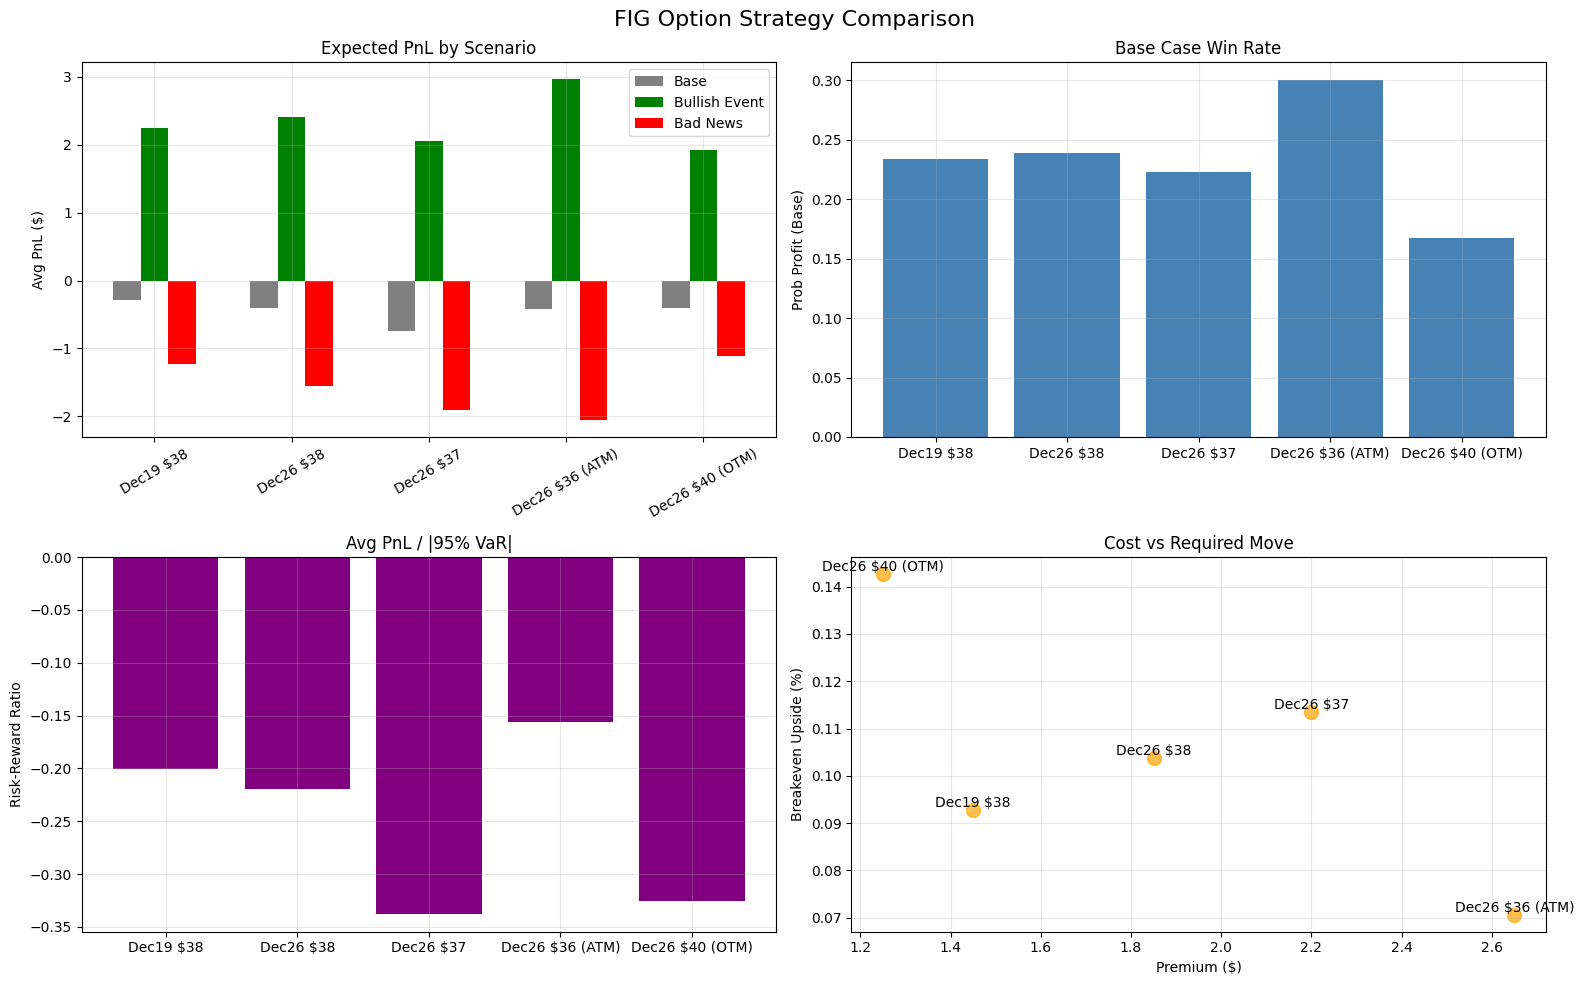

📊 OPTION STRATEGY COMPARISON (Base Case)
          Label  Premium  Breakeven  Base_Prob_Profit  Base_Avg_PnL  VaR_95_Base  Sharpe_Base
      Dec19 $38     1.45      39.45              0.23         -0.29        -1.45        -0.12
      Dec26 $38     1.85      39.85              0.24         -0.41        -1.85        -0.14
      Dec26 $37     2.20      40.20              0.22         -0.74        -2.20        -0.26
Dec26 $36 (ATM)     2.65      38.65              0.30         -0.41        -2.65        -0.12
Dec26 $40 (OTM)     1.25      41.25              0.17         -0.41        -1.25        -0.18

🔍 EARLY WARNING CHECK
✅ No immediate risk triggers

🎯 Deep Dive: Dec26 $38 Call — FIG Bullish Event Scenario
  → Prob Profit: 47.6%
  → Avg PnL: $+1.97
  → 95% VaR: $-2.30


In [11]:

# ───────────────────────────────────────
# 🚀 Usage Example
# ───────────────────────────────────────
if __name__ == "__main__":
    # Initialize analyzer
    analyzer = FIGOptionAnalyzer(S0=36.10, iv_current=0.60, n_sim=50_000)  # Faster for demo
    
    # Define option strategies to compare
    options_to_test = [
        {'T_days': 12, 'K': 38, 'premium': 1.45, 'label': 'Dec19 $38'},
        {'T_days': 16, 'K': 38, 'premium': 1.85, 'label': 'Dec26 $38'},  # Your focus
        {'T_days': 16, 'K': 38, 'premium': 2.20, 'label': 'Dec26 $37'},
        {'T_days': 16, 'K': 36, 'premium': 2.65, 'label': 'Dec26 $36 (ATM)'},
        {'T_days': 16, 'K': 40, 'premium': 1.25, 'label': 'Dec26 $40 (OTM)'},
    ]
    
    # Run comparison
    print("Running multi-option risk analysis...\n")
    results_df = analyzer.compare_options(options_to_test, event_day=10)
    
    # Display summary table
    pd.set_option('display.precision', 2)
    print("📊 OPTION STRATEGY COMPARISON (Base Case)")
    print(results_df[[
        'Label', 'Premium', 'Breakeven', 
        'Base_Prob_Profit', 'Base_Avg_PnL', 
        'VaR_95_Base', 'Sharpe_Base'
    ]].to_string(index=False))
    
    # Check risk triggers
    print("\n🔍 EARLY WARNING CHECK")
    alerts = analyzer.check_risk_triggers(
        current_price=36.10,
        current_iv=0.60,
        support_level=34.50,
        iv_crush_threshold=0.50
    )
    for alert in alerts:
        print(alert)
    
    # Optional: Drill into one scenario
    print("\n🎯 Deep Dive: Dec26 $38 Call — FIG Bullish Event Scenario")
    single_res = analyzer.analyze_option(T_days=16, K=38, premium=2.30)
    bull = single_res['FIG_Event_Bullish']
    print(f"  → Prob Profit: {bull['Prob_Profit']:.1%}")
    print(f"  → Avg PnL: ${bull['Avg_PnL']:+.2f}")
    print(f"  → 95% VaR: ${bull['VaR_95']:+.2f}")